<a href="https://colab.research.google.com/github/Taigaoon/models/blob/master/ss_born3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chainercv

In [ ]:
import chainer
import cupy
import chainercv
import matplotlib

In [ ]:
!unzip "drive/My Drive/ss_born/train.zip"
!unzip "drive/My Drive/ss_born/val.zip"

Archive:  drive/My Drive/ss_born/train.zip
replace train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A,y
  inflating: train/.DS_Store         
  inflating: __MACOSX/train/._.DS_Store  
  inflating: __MACOSX/train/._image  
  inflating: train/label/ 148.jpg    
  inflating: __MACOSX/train/label/._ 148.jpg  
  inflating: train/label/ 160.jpg    
  inflating: __MACOSX/train/label/._ 160.jpg  
  inflating: train/label/ 174.jpg    
  inflating: __MACOSX/train/label/._ 174.jpg  
  inflating: train/label/ 82.jpg     
  inflating: __MACOSX/train/label/._ 82.jpg  
  inflating: train/label/ 96.jpg     
  inflating: __MACOSX/train/label/._ 96.jpg  
  inflating: train/label/ 69.jpg     
  inflating: __MACOSX/train/label/._ 69.jpg  
  inflating: train/label/ 41.jpg     
  inflating: __MACOSX/train/label/._ 41.jpg  
  inflating: train/label/ 55.jpg     
  inflating: __MACOSX/train/label/._ 55.jpg  
  inflating: train/label/ 54.jpg     
  inflating: __MACOSX/train/label/._ 54.jpg  
  inflating: 

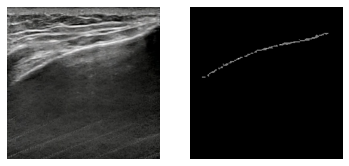

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# PILライブラリで画像を読み込む
img = np.asarray(Image.open('train/image/ 00.jpg'))
label = np.asarray(Image.open('train/label/ 00.jpg'))

# matplotlibライブラリを使って2つの画像を並べて表示
fig, axes = plt.subplots(1, 2)
axes[0].set_axis_off()
axes[0].imshow(img, cmap='gray')
axes[1].set_axis_off()
axes[1].imshow(label, cmap='gray')
plt.show()

In [ ]:
import glob
from chainer import datasets

def create_dataset(img_filenames, label_filenames):
    img = datasets.ImageDataset(img_filenames)
    img = datasets.TransformDataset(img, lambda x: x / 255.)  # 0-1に正規化
    label = datasets.ImageDataset(label_filenames, dtype=np.int32)
    dataset = datasets.TupleDataset(img, label)
    return dataset

In [ ]:
def create_datasets():
    # Python標準のglobを使ってMRI画像ファイル名/ラベル画像ファイル名の一覧を取得
    train_img_filenames = sorted(glob.glob('train/image/*.jpg'))
    train_label_filenames = sorted(glob.glob('train/label/*.jpg'))

    # リストを渡して，データセットオブジェクト train を作成
    train = create_dataset(train_img_filenames, train_label_filenames)

    # 同様のことをvalidationデータに対しても行う
    val_img_filenames = sorted(glob.glob('val/image/*.jpg'))
    val_label_filenames = sorted(glob.glob('val/label/*.jpg'))
    val = create_dataset(val_img_filenames, val_label_filenames)

    return train, val

In [ ]:
train, val = create_datasets()

print('Dataset size:\n\ttrain:\t{}\n\tvalid:\t{}'.format(len(train), len(val)))

Dataset size:
	train:	200
	valid:	20


In [ ]:
from chainer import reporter
from chainer import cuda
from chainercv import evaluations
import chainer
import chainer.functions as F
import chainer.links as L

class FullyConvolutionalNetwork(chainer.Chain):

    def __init__(self, out_h, out_w, n_class=1):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # とかくこともできます．
            self.conv1 = L.Convolution2D(None, 64, ksize=5, stride=2, pad=2)
            self.conv2 = L.Convolution2D(None, 128, ksize=5, stride=2, pad=2)
            self.conv3 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.conv5 = L.Convolution2D(None, 128, ksize=1, stride=1, pad=0)
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書くこともできます．
            self.deconv6 = L.Deconvolution2D(None, n_class, ksize=32, stride=16, pad=8)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = self.deconv6(h)

        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])

print(FullyConvolutionalNetwork(256, 256)(np.zeros((1, 1, 256, 256), dtype=np.float32)).shape[2:])

(256, 256)


In [ ]:
class PixelwiseSigmoidClassifier(chainer.Chain):

    def __init__(self, predictor):
        super().__init__()
        with self.init_scope():
            # 学習対象のモデルをpredictorとして保持しておく
            self.predictor = predictor

    def __call__(self, x, t):
        # 学習対象のモデルでまず推論を行う
        y = self.predictor(x)

        # 2クラス分類の誤差を計算
        loss = F.sigmoid_cross_entropy(y, t)

        # 予測結果（0~1の連続値を持つグレースケール画像）を二値化し，
        # ChainerCVのeval_semantic_segmentation関数に正解ラベルと
        # 共に渡して各種スコアを計算
        y, t = cuda.to_cpu(F.sigmoid(y).data), cuda.to_cpu(t)
        y = np.asarray(y > 0.5, dtype=np.int32)
        y, t = y[:, 0, ...], t[:, 0, ...]
        evals = evaluations.eval_semantic_segmentation(y, t)

        # 学習中のログに出力
        reporter.report({'loss': loss,
                         'miou': evals['miou'],
                         'pa': evals['pixel_accuracy']}, self)
        return loss

In [ ]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions

def create_trainer(batchsize, train, val, stop, device=-1, log_trigger=(1, 'epoch')):
    model = FullyConvolutionalNetwork(out_h=256, out_w=256)
    train_model = PixelwiseSigmoidClassifier(model)

    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')

    logging_attributes = [
        'epoch', 'main/loss', 'main/miou', 'main/pa',
        'val/main/loss', 'val/main/miou', 'val/main/pa']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(extensions.PlotReport(['main/pa', 'val/main/pa'], 'epoch', file_name='pa.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer


In [ ]:
%%time
trainer = create_trainer(16, train, val, (150, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.0217041   0.331489    0.99179     0.0222302      0.331703       0.991545     
20          0.0161926   0.372472    0.99194     0.0167891      0.412369       0.992063     
30          0.0148129   0.443679    0.99262     0.0145562      0.464519       0.993039     
40          0.0143094   0.457962    0.99284     0.0138876      0.46509        0.993206     
50          0.0136642   0.446533    0.993171    0.0138266      0.448594       0.99308      
60          0.0136782   0.456484    0.993194    0.013349       0.461724       0.993441     
70          0.0137704   0.459997    0.993161    0.0136177      0.46531        0.993287     
80          0.013151    0.467948    0.993527    0.0133568      0.47013        0.993398     
90          0.0131548   0.456345    0.993608    0.0131819      0.463509       0.993548     
100         0.0133733   0.470873    0.993385    0.0133383      0.469632       0.99

Loss


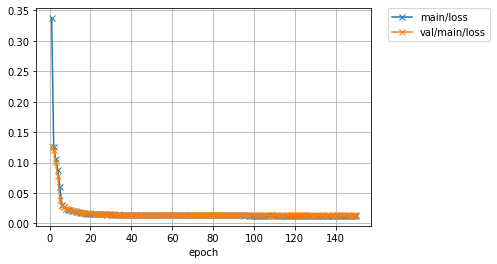

In [ ]:
from IPython.display import Image
print('Loss')
Image('result_fcn/loss.png')

mean IoU


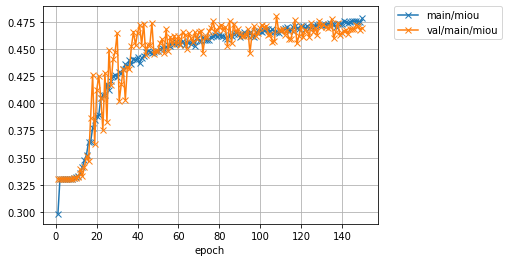

In [ ]:
print('mean IoU')
Image('result_fcn/miou.png')

Pixel Accuracy


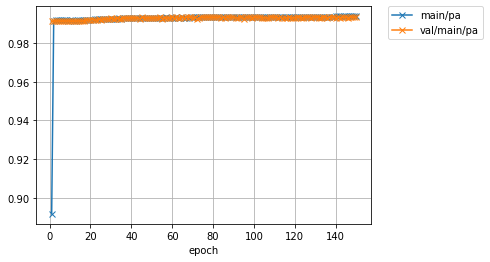

In [ ]:
print('Pixel Accuracy')
Image('result_fcn/pa.png')

In [ ]:
from chainer import cuda
from chainercv import evaluations

def evaluate(trainer, val, device=-1):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    # validationデータ全部に対して予測を行う
    preds = []
    for img, label in val:
        img = cuda.to_gpu(img[np.newaxis], device)
        pred = model(img)
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        preds.append((pred, label[0]))
    pred_labels, gt_labels = zip(*preds)

    # 評価をして結果を表示
    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIoU:', evals['miou'])

evaluate(trainer, val, device=0)

Pixel Accuracy: 0.9935302734375
mIoU: 0.47133841540050203


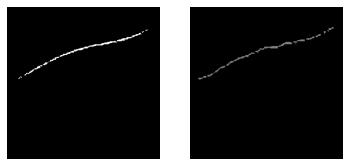

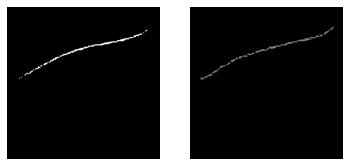

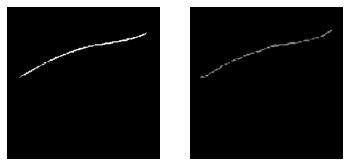

In [ ]:
def show_predicts(trainer, val, device=-1, n_sample=3):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
        img, label = val[i]
        img = cuda.to_gpu(img, device)
        pred = model(img[np.newaxis])
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        fig, axes = plt.subplots(1, 2)

        axes[0].set_axis_off()
        axes[0].imshow(pred, cmap='gray')

        axes[1].set_axis_off()
        axes[1].imshow(label[0], cmap='gray')

        plt.show()

show_predicts(trainer, val, device=0)